In [63]:
import numpy as np
import matplotlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative
from scipy.integrate import solve_bvp
from scipy import special as sp
import plasmapy.mathematics
import scipy.optimize as op
from functools import partial
from scipy import integrate
from prettytable import PrettyTable
%config InlineBackend.figure_format = 'svg'

In [265]:
tem = 1
L = 10
vmax = 10
grid_num = 100
N = 500000

nx = grid_num+1
#nx = 101
nv = 101
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)

dt = 0.1
max_steps  = 10000
data_steps = 1000
data_num = int(max_steps/data_steps) + 1

uae = 0.3
uai = 0.2

path = '../data/'

m=1
n=N/L
q=np.sqrt(1/n)
v_th = np.sqrt(2*tem)
l_D = np.sqrt( tem) # $\lambda_D^2$
w_pe = 1
print("data_num = ",data_num)

data_num =  11


In [266]:
k = 1 * 2*np.pi/L
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
print("k = ",k)
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
v_p = s.x[0]/k
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("v_p = ",v_p)
#print("t_B = ", abs(1/np.sqrt(q*abs(fx_theo(L/2)-uai))))
print("t_B = ", abs(1/np.sqrt(q*abs(uae-uai))))
print("t_L = ", abs(1/s.x[1]))
print('rtime = ', max_steps*dt)

k =  0.6283185307179586
w_r =  1.582211015285451
w_i =  -0.2988506035471682
v_p =  2.518167040971259
t_B =  47.28708045015879
t_L =  3.346153523301043
rtime =  1000.0


## 理论预测

In [267]:
def fm(v, t):
    r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    return r
def fk(v, t, kappa):
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
def ue(x):
    r = 1.+uae*np.cos(k * x)
    return r
def ui(x):
    r = 1.+uai*np.cos(k * x)
    return r

In [268]:
#theoretical initial energy
def efield2(x):
    r =( (N/L)*q*(uai-uae) * np.sin(k*x)/k )**2
    return r

Ep_init = 0.5*integrate.quad(efield2,0,L)[0]/N
Ek_init = 0.5*tem
Et_init = Ek_init + Ep_init

#theoretical initial entropy
def entropy(x,v):
    ufv = fm(v, tem)*ue(x)/L
    if (ufv==0.0):
        r = 0.0
    else:
        r = ufv**2
        #r = -ufv * np.log(ufv)
    return r
options = {'limit':50000}
entropyt_int_res = integrate.nquad(entropy,[[0,L],[-np.inf,np.inf]], opts=[options,options])
S_init = entropyt_int_res[0]

In [269]:
def ug(x):
    r = (1. + uai * np.cos(k*x)) #/ (2*1.*a)
    return r

def ug_dev(x):
    r = -uai*k*np.sin(k*x)#/ 2. / a
    return r

def eq4U(x,yy,p):
    kappa,t=p
    dy, y = yy
    k_factor = (kappa+2) / (kappa+1)
    dy2y = (dy**2) / y
    ddy = k_factor * dy2y + (kappa+1) / (kappa) * (y**k_factor) * ( y-ui(x) ) / t * n * (q**2)
    return np.vstack((ddy, dy))

def bc4U(ya, yb):
    return np.array([ya[0]-yb[0],ya[1]-yb[1]])

xi = np.linspace(0, L, num=5000, dtype='complex',endpoint=False)
yguess = np.array([ug_dev(xi), ui(xi)])

def eq4para(x,energy,entropy):
    kp,tp = x
    sol4ode = solve_bvp(partial(eq4U, p=x), bc4U, xi,
                        yguess, tol=1e-13, max_nodes=50000)

    def ff(x):
        return sol4ode.sol(x)[1]
    def ff_r(x):
        return ff(x).real
    def ff_i(x):
        return ff(x).imag

    def ff_inti(x):
        r = ff(x)**(kp/(kp+1))
        return r
    def ff_inti_r(x):
        return ff_inti(x).real
    def ff_inti_i(x):
        return ff_inti(x).imag
        
    def ff_intii(x):
        r = ui(x) * (ff(x) ** (-1.0/(kp+1)))
        return r
    def ff_intii_r(x):
        return ff_intii(x).real
    def ff_intii_i(x):
        return ff_intii(x).imag
    
    def ff_intiii(x):
        r = ff(x)**(-1./(kp+1))
        return r
    def ff_intiii_r(x):
        return ff_intiii(x).real
    def ff_intiii_i(x):
        return ff_intiii(x).imag
    
    def entropy_pred(x, v):
        U_x = ff(x)
        
        if(kp==0):
            t_x = tp
            tempf = U_x * fm(v, t_x)+0j
        else:
            t_x = tp * U_x ** (-1./(kp+1))
            tempf = U_x * fk(v, t_x, kp)/L+0j
        if (tempf == 0.0+0.0j):
            r = 0.0
        else:
            r = tempf**2
            #r = -tempf * np.log(tempf)
        r = tempf**2
        #r = -tempf * np.log(tempf)
        return r
    def entropy_pred_r(x,v):
        return entropy_pred(x,v).real
    def entropy_pred_i(x,v):
        return entropy_pred(x,v).imag
    entropy_pred_int_r = integrate.dblquad(
        entropy_pred_r, -np.inf, np.inf,  0,  L, epsrel=1e-10)
    entropy_pred_int_i = integrate.dblquad(
        entropy_pred_i, -np.inf, np.inf,  0,  L, epsrel=1e-10)
    entropyp = entropy_pred_int_r[0] + 1j * entropy_pred_int_i[0]

    int_ff_r = integrate.quad(ff_r, 0, L, epsrel=1e-10)[0]-1.0
    int_ff_i = integrate.quad(ff_i, 0, L, epsrel=1e-10)[0]-1.0
    int_ff = int_ff_r + 1j * int_ff_i
    
    int_i_r = integrate.quad(ff_inti_r, 0, L, epsrel=1e-10)[0]
    int_i_i = integrate.quad(ff_inti_i, 0, L, epsrel=1e-10)[0]
    int_i = int_i_r + 1j * int_i_i

    int_ii_r = integrate.quad(ff_intii_r, 0, L, epsrel=1e-10)[0]
    int_ii_i = integrate.quad(ff_intii_i, 0, L, epsrel=1e-10)[0]
    int_ii = int_ii_r + 1j * int_ii_i

    int_iii_r = integrate.quad(ff_intiii_r, 0, L, epsrel=1e-10)[0]
    int_iii_i = integrate.quad(ff_intiii_i, 0, L, epsrel=1e-10)[0] 
    int_iii = (int_iii_r + 1j * int_iii_i) * int_ff

    eq1 = ((energy*2)*L - tp * (1+kp) * int_i + tp * kp * int_ii)/(energy*2)/L
    eq2 = (entropyp-entropy)/entropy

    return eq1.real,eq2.real

In [270]:
#para[0] for kappa, para[1] for T_0
para_guess = [0.14708099,2.83689694]# initial guess of parameters
#para_guess = [0.014708099,28.3689694]
#para_guess = [1.47030322,1.33796874]

sol_para = op.root(partial(eq4para,energy=Et_init,entropy=S_init), para_guess, method='hybr')
#sol_para = op.root(partial(eq4para,energy=efin,entropy=entropyf), para_guess, method='hybr')
para = sol_para.x

print(para)
print(sol_para.fun,sol_para.success)

[5.32793575 1.01024647]
[ 0.00000000e+00 -1.05923276e-15] True


In [271]:
yguess = np.array([ug_dev(xi), ui(xi)])
sol = solve_bvp(partial(eq4U,p=para), bc4U, xi, yguess,tol=1e-13,max_nodes=50000)
#theoretical n
def fx_theo(x):
    return sol.sol(x)[1].real
#theoretical T
def t_theo(x):
    return para[1]*(fx_theo(x).real)**(-1.0/(para[0]+1))
#theoretical pdf
def fk_xv(x,v,k,t):
    if(k==0):
        s = fx_theo(x)*np.sqrt( fx_theo(x)**( 1./(k+1) ) / (2*np.pi*t) )/L
        m = np.exp(-v**2 / (2*t) * fx_theo(x)**(1./(k+1)))
        r = s*m
    else:
        s = fx_theo(x)*np.sqrt( fx_theo(x)**( 1./(k+1) ) / (2*np.pi*t*k) )/L
        frac = sp.gamma(k+1.5) / sp.gamma(k+1)
        m = ( 1+ (v)**2 / (k*2*t) * fx_theo(x)**(1./(k+1)) )**(-k-1.5)
        r = s*frac*m
    return r.real
def fk_v_nonvec(vv,kk,tt):
    r = integrate.quad(partial(fk_xv,v=vv,k=kk,t=tt),0,L)[0]
    return r
fk_v = np.vectorize(fk_v_nonvec)

## 模拟结果

In [284]:
progesses = np.arange(0,data_num,1)

xdata = []
vdata = []
tdata = []

for progess in progesses:
    x_temp = np.loadtxt(os.path.join(path,"electronsx_data"+str(progess)))
    xdata.append(x_temp)
    v_temp = np.loadtxt(os.path.join(path,"electronsv_data"+str(progess)))
    vdata.append(v_temp)
    t_temp = np.loadtxt(os.path.join(path,"temperature"+str(progess)))
    tdata.append(t_temp)

In [285]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

In [286]:
def pdf(data,data_bins):##统计分布函数
    f, edges = np.histogram(data, bins=data_bins, density=True)
    x = (edges[0:len(edges)-1]+edges[1:len(edges)])/2
    dx = edges[1]-edges[0]
    return f, x, dx
def pdf2d(x,y,datax_bins,datay_bins):
    f,xedges,yedges = np.histogram2d(x,y,bins=[datax_bins,datay_bins],density=True)
    x = (xedges[0:len(xedges)-1]+xedges[1:len(xedges)])/2
    y = (yedges[0:len(yedges)-1]+yedges[1:len(yedges)])/2
    dx = xedges[1]-xedges[0]
    dy = yedges[1]-yedges[0]
    return f,x,y,dx,dy

In [287]:
def e(pdf,xw,vw):
    r = 0.0
    for x in pdf:
        for i in x:
            if i == 0.0:
                r += 0.0
            else: 
                r += i**2
                #r +=- i * np.log(i)
    return r * vw * xw

fxv, x_fxv, v_fxv, dx_fxv,dv_fxv = pdf2d(xdata[data_num-1],vdata[data_num-1],nx,nv)
Ek_fin = dataek[max_steps-1]
Ep_fin = dataep[max_steps-1]
Et_fin = dataet[max_steps-1]
S_fin = e(fxv,dx_fxv,dv_fxv)

In [288]:
err_E = (Et_init-Et_fin)/Et_init*100
err_S = (S_init-S_fin)/S_init*100
table = PrettyTable(['',  'Ek',    'Ep',    'Et',    'S'])
table.add_row(['initial',  Ek_init, Ep_init, Et_init, S_init])
table.add_row(['final',    Ek_fin,  Ep_fin,  Et_fin,  S_fin])
table.add_row(['error(%)', '-',     '-',     err_E,   err_S])
table.float_format = .6
print(table)

+----------+----------+----------+----------+----------+
|          |    Ek    |    Ep    |    Et    |    S     |
+----------+----------+----------+----------+----------+
| initial  | 0.500000 | 0.006333 | 0.506333 | 0.029479 |
|  final   | 0.504865 | 0.001122 | 0.505988 | 0.029234 |
| error(%) |    -     |    -     | 0.068105 | 0.831755 |
+----------+----------+----------+----------+----------+


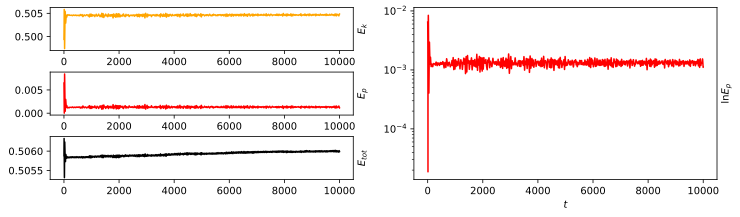

In [289]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

In [290]:
#initial pdf
fv0,v_fv0,dv_fv0 = pdf(vdata[0],nv)
fx0,x_fx0,dx_fx0 = pdf(xdata[0],nx)
#final pdf
fv,v_fv,dv_fv=pdf(vdata[data_num-1],nv)
fx,x_fx,dx_fx=pdf(xdata[data_num-1],nx)
#initial T
Z0,x_Z0,v_Z0,dx_Z0,dv_Z0 = pdf2d(xdata[0],vdata[0],nx,nv)
Zx0 = np.sum(Z0,axis=1)*dv_Z0
T0 = np.sum(v_Z0**2*Z0,axis=1)*dv_Z0/Zx0
#final T
Z,x_Z,v_Z,dx_Z,dv_Z = pdf2d(xdata[data_num-1],vdata[data_num-1],nx,nv)
Zx = np.sum(Z,axis=1)*dv_Z
T = np.sum(v_Z**2*Z,axis=1)*dv_Z/Zx

In [291]:
chi = np.sum( (fv-fk_v(v_fv, para[0],para[1]))**2 )*dv
chi_str = print('from k pdf %.8f' % chi)
chi_m = np.sum( (fv-fm(v_fv,para[1]))**2 )*dv
chi_m_str = print('from M pdf %.8f' % chi_m)

from k pdf 0.00090103
from M pdf 0.00144189


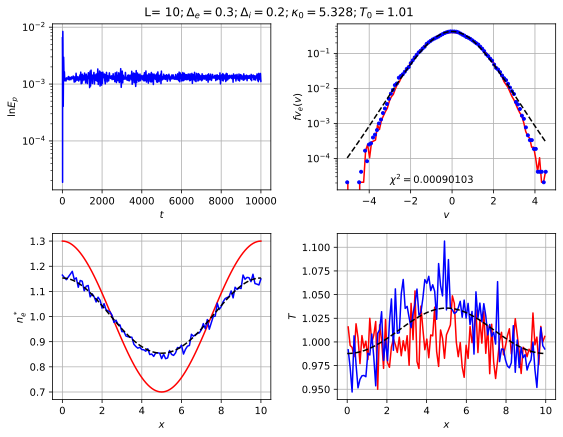

In [295]:
fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(t, dataep, color='blue')
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\ln E_p$')
ax1.set_yscale('log')
ax1.grid()

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(v_fv0,fv0,color='red', label='initial')
ax2.plot(v_fv, fv, '.',color='blue',label='final')
ax2.plot(v_fv, fk_v(v_fv, para[0],para[1]),'--',color='black',label='theory')
ax2.text(-3,2e-5,r'$\chi^2 = $'+('%.8f' % chi))
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$fv_{e}(v)$')
ax2.set_yscale('log')
ax2.grid()

ax3 = plt.subplot2grid((2, 2), (1, 0))
ax3.plot(x, ue(x), color='r',    label='initial')
ax3.plot(x, fx*L,  color='blue', label='final')
ax3.plot(x, fx_theo(x), '--', color='black', label='theo')
ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$n_e^*$')
ax3.grid()

#x_tdata = x[0:nx-1]+dx/2
ax4 = plt.subplot2grid((2, 2), (1, 1))
ax4.plot(x_Z0, T0, color='r',   label='initial')
ax4.plot(x_Z, T ,color='blue',label='final')
ax4.plot(x, t_theo(x), '--', color='black', label='theo')
#plt.plot(x_tdata,tdata[data_num-1],color='orange')
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$T$')
ax4.grid()

title_text = "L= " + str(L) + r"$; \Delta_e= $" + str(uae) + r"$; \Delta_i= $" + \
    str(uai) + r"$; \kappa_0= $" + str(round(para[0],3)) + r"$; T_0= $" + str(round(para[1],3))
fig.suptitle(title_text,va='bottom')
plt.tight_layout()
#plt.savefig("../results/15.png", dpi=600,bbox_inches = 'tight')
plt.show()

In [293]:
from scipy.misc import derivative

In [282]:
def f(x):
    return x**2
fp = derivative(f,x)

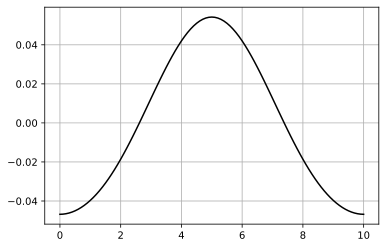

In [283]:
plt.plot(x,fx_theo(x)-ui(x),color='black')
plt.grid()
plt.show()

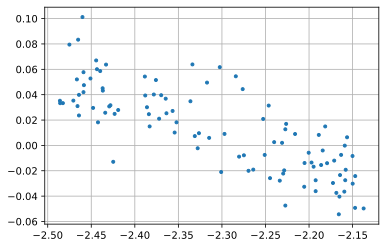

In [294]:
plt.plot(np.log(fx),np.log(T),'.',markersize=6)
plt.grid()
plt.show()